# Assignment #2: Extraction of Named Entities: 
Author: Pierre Nugues

In this assignment, you will create a system to extract named entities from a text. You will use the CoNLL 2003 dataset and you will train your models with PyTorch.

Be aware that with PyTorch, the data matrices, by default, have an unconventional ordering with recurrent networks. To have a batch ordering similar to what we saw during the course, you must use the `batch_first=True` argument. See here https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html and https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Before you start the assignment, please run the prerequistites notebook. The 100d vectors should give better results than the 50d, but they take a longer time to train. Start with the 50d vectors. Then, optionally, run the experiments with 100d vectors, if your machine is fast enough.

## Objectives

The objectives of this assignment are to:
* Write a program to recognize named entities in text
* Learn how to manage a text data set
* Apply recurrent neural networks to text with PyTorch
* Know what word embeddings are
* Write a short report of 2 to 3 pages on your experiments. This report is mandatory to pass the assignment.

## Organization and location

You can work alone or collaborate with another student:
* Each group will have to write Python programs to recognize named entities in text.
* You will have to experiment different architectures, namely RNN and LSTM, and compare the results you obtained.
* Each student will have to write an individual report on these experiments.

## Preliminaries

### Imports
For the vector and matrix operations, use pytorch only. __Do not use numpy__.

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

import conlleval

### Seeds
Making things reproduceable

In [3]:
random.seed(1234)
torch.manual_seed(1234)

### Constants

In [4]:
EPOCHS = 10
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 2
DROPOUT = 0.20
EMB_LARGE = False # GloVe 50 or 100
FREEZE_EMBS = True
LARGE_MEM = False

In [5]:
config = {'EPOCHS': EPOCHS, 
'LSTM_HIDDEN_DIM': LSTM_HIDDEN_DIM,
'LSTM_LAYERS': LSTM_LAYERS,
'DROPOUT': DROPOUT,
'EMB_LARGE': EMB_LARGE,
'FREEZE_EMBS': FREEZE_EMBS}

### The datasets

You may need to adjust the paths to load the datasets from your machine.

In [6]:
train_file = 'conll2003/train.txt'
val_file = 'conll2003/valid.txt'
test_file = 'conll2003/test.txt'

## Reading the files

You will now convert the dataset in a Python data structure. Read the functions below to load the datasets. They store the corpus in a list of sentences. Each sentence is a list of rows, where each row is a dictionary.

In [7]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [8]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2002 files have four columns: The wordform, `form`, its predicted part of speech, `ppos`, the predicted tag denoting the syntactic group also called the chunk tag, `pchunk`, and finally the named entity tag `ner`.

In [9]:
column_names = ['form', 'ppos', 'pchunk', 'ner']

We load the corpus as a list of dictionaries

In [10]:
train_sentences = read_sentences(train_file)
train_dict = split_rows(train_sentences, column_names)

val_sentences = read_sentences(val_file)
val_dict = split_rows(val_sentences, column_names)

train_dict[1]

[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'},
 {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'},
 {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
 {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
 {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'},
 {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'},
 {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'},
 {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]

## Embeddings

### Reading the embeddings

Adjust your folders

In [11]:
if EMB_LARGE:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

Apply the function below that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embedding vectors.

In [12]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [13]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

In [14]:
'# words in embedding dictionary: {}'.format(len(embedded_words))

'# words in embedding dictionary: 400000'

### Understanding the embeddings

In [15]:
embedded_words[100000:100010]

['chording',
 'chordoma',
 'chordophones',
 'chords',
 'chore',
 'chorea',
 'chorene',
 'choreograph',
 'choreographed',
 'choreographer']

In [16]:
embeddings_dict['chords'][:20]

tensor([-0.4040, -0.0786, -0.2163, -0.2406, -0.2300,  1.0956,  0.9115,  0.7881,
        -0.9250,  1.1640, -0.1718,  0.5499, -0.5291,  1.0982, -1.1583, -0.4945,
        -0.5830, -0.6904,  0.4173, -0.8306])

#### Embedding Matrix
For the vectors in `embeddings_dict`, create a unique `E` matrix of the embeddings. To keep track of the word index, create also an `emb_word_idx` dictionary that will associate the row index its corresponding word.

To build `E`, you may first store the vectors in a list and then use `torch.stack()` to convert it in a tensor.

In [17]:
# Write your code
E = []
emb_word_idx = {}
...

In [18]:
emb_word_idx[21359]

'chords'

In [19]:
E[21359][:20]

tensor([-0.4040, -0.0786, -0.2163, -0.2406, -0.2300,  1.0956,  0.9115,  0.7881,
        -0.9250,  1.1640, -0.1718,  0.5499, -0.5291,  1.0982, -1.1583, -0.4945,
        -0.5830, -0.6904,  0.4173, -0.8306])

Normalize the rows so that each row has a norm of 1

In [20]:
# Write your code here
...

Using a cosine similarity, write a `closest(target_word_embeddings, embeddings, count=10)` that computes the 10 closest rows of a given vector `target_word_embeddings`.

Remember that:
$$
\cos(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}|| ||\mathbf{v}||}
$$

In [21]:
# Write your code here
def closest(target_word_emb, E, count=10):
...

Using the `closest()` function find the words closest to _table_, _france_, and _sweden_.

In [22]:
embeddings_dict['table'][:20]

tensor([-0.3666,  1.0584, -0.6538,  0.1767,  1.0605, -0.7254, -0.0097,  0.0797,
        -0.4649, -0.7435, -0.6415, -0.1684, -0.4893,  0.5667,  0.7310,  0.1839,
         0.3437, -0.1916,  0.0661, -1.3434])

In [23]:
closest(embeddings_dict['table'], E, count=10)

[7221, 241, 3162, 208, 310, 802, 187, 236, 2389, 220]

In [24]:
list(map(emb_word_idx.get, closest(embeddings_dict['france'], E, count=10)))

['french',
 'belgium',
 'paris',
 'spain',
 'netherlands',
 'italy',
 'germany',
 'european',
 'switzerland',
 'europe']

## Extracting the ${X}$ and ${Y}$ Lists of Symbols from the Datasets

For each sentence, you will build an input sequence, $\mathbf{x}$, corresponding to the words and an output one, $\mathbf{y}$, corresponding to the NER tags.

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that, for each sentence, returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and chunk tags. Set the words in lower case if `tolower` is true.

For the 2nd sentence of the training set, you should have:<br/>
`x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']`

`y = ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']`

In [25]:
# Write your code
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
   ...

In [26]:
X_train_symbs, Y_train_symbs = build_sequences(train_dict, key_x='form', key_y='ner')
X_val_symbs, Y_val_symbs = build_sequences(val_dict, key_x='form', key_y='ner')

In [27]:
X_train_symbs[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [28]:
Y_train_symbs[1]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

## Vocabulary

Create a vocabulary of all the words observed in the training set as well as in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words `words` from the CoNLL training set and the list of NER tags, `ner`. You will sort them

In [29]:
# Write your code: List of words and tags in CoNLL
...

In [30]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(tags))

# words seen in training corpus: 21010
# NER tags seen: 9


In [31]:
words[4000:4010]

['adequate',
 'adige',
 'adj',
 'adjourned',
 'adjust',
 'adjusted',
 'adjusting',
 'adjustments',
 'adkins',
 'administer']

In [32]:
tags[:10]

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Then, merge the list of unique CoNLL words with the words in the embeddings file. You will sort this list

In [33]:
# Write your code: Add vocabulary of embedded words
...

In [34]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


In [35]:
vocabulary_words[200000:200010]

['jmurray',
 'jmw',
 'jmy',
 'jn',
 'jn-4',
 'jna',
 'jnana',
 'jnanpith',
 'jnc',
 'jne']

## Index

Create the indices `word2idx`, `tag2idx` and inverted indices `idx2word`, `idx2tag` for the words and the tags: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words. This means that your first word will start at index 2. For the tags, you will start at index 1.

In [36]:
# Write your code:
...

The word indices

In [37]:
print(list(word2idx.items())[:25])

[('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]


The tag indices

In [38]:
print(tag2idx)

{'B-LOC': 1, 'B-MISC': 2, 'B-ORG': 3, 'B-PER': 4, 'I-LOC': 5, 'I-MISC': 6, 'I-ORG': 7, 'I-PER': 8, 'O': 9}


## Embedding Matrix

Create a numpy matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `torch.rand()`

In [39]:
# We add two dimensions for the padding symbol at index 0 and unknown words at index 1
embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))/10 - 0.05 # range: -0.05, 0.05, 
# embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))
# embedding_matrix = torch.zeros((len(vocabulary_words) + 2, EMBEDDING_DIM))

The shape of your matrix is: (402597, 100) or (402597, 50)

In [40]:
embedding_matrix.shape

torch.Size([402597, 50])

Fill the matrix with the GloVe embeddings when available. This means: Replace the random vector with an embedding when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [41]:
# Write your code
out_of_embeddings = []
...

In [42]:
len(out_of_embeddings)

2595

In [43]:
out_of_embeddings[-10:]

['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

Embeddings of the padding symbol, idx 0, random numbers

In [44]:
embedding_matrix[0][:10]

tensor([-0.0471, -0.0098, -0.0240, -0.0133, -0.0442,  0.0201, -0.0448, -0.0032,
         0.0174, -0.0169])

Embeddings of the word _table_, the GloVe values

In [45]:
embedding_matrix[word2idx['table']][:10]

tensor([-0.3666,  1.0584, -0.6538,  0.1767,  1.0605, -0.7254, -0.0097,  0.0797,
        -0.4649, -0.7435])

Embeddings of _zarett_, a word in CoNLL 2003, but not in GloVe, random numbers

In [46]:
embedding_matrix[word2idx['zwingmann']][:10]

tensor([-0.0014,  0.0307,  0.0219, -0.0102,  0.0266,  0.0387, -0.0300, -0.0342,
         0.0384,  0.0363])

## Creating the ${X}$ and ${Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the 
${X}_\text{train\_symbs}$ and ${Y}_\text{train\_symbs}$ 
lists of symbols in lists of numbers using the indices you created. Call them `X_train_idx` and `Y_train_idx`.

In [47]:
# Write your code
# We create the parallel sequences of indexes
X_train_idx = []
Y_train_idx = []
...

Do the same for the validation set. Be aware that some words may be unknown.

In [48]:
# Write your code
# We create the parallel sequences of indexes
X_val_idx = []
Y_val_idx = []
...

Word indices of the three first sentences

In [49]:
print(X_train_idx[:3])
print(X_val_idx[:3])

[[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
[[935], [113351, 679, 221875, 354360, 275584, 63471, 364505, 49150, 192163, 381011, 936], [227217, 15431]]


NER tag indices of the three first sentences

In [50]:
print(Y_train_idx[:3])
print(Y_val_idx[:3])

[[9], [3, 9, 2, 9, 9, 9, 2, 9, 9], [4, 8]]
[[9], [9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9], [1, 9]]


Now, pad the sentences using the `pad_sequences` function. After padding, the second sentence you look like (the indices are not necessarily the same).


```
x = tensor([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,    936,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0])
y = tensor([3, 9, 2, 9, 9, 9, 2, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
```

You will call the results `X_train_padded` and `Y_train_padded`. Do the same for the validation set.

In [51]:
X_train_idx = list(map(torch.LongTensor, X_train_idx))
Y_train_idx = list(map(torch.LongTensor, Y_train_idx))

X_val_idx = list(map(torch.LongTensor, X_val_idx))
Y_val_idx = list(map(torch.LongTensor, Y_val_idx))

In [52]:
# Write your code here
X_train_padded = pad_sequence(X_train_idx, batch_first=True)
Y_train_padded = pad_sequence(Y_train_idx, batch_first=True)

X_val_padded = pad_sequence(X_val_idx, batch_first=True)
Y_val_padded = pad_sequence(Y_val_idx, batch_first=True)

In [53]:
X_train_padded[1]

tensor([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,    936,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [54]:
Y_train_padded[1]

tensor([3, 9, 2, 9, 9, 9, 2, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Network Architecture

Create your network consisting of one embedding layer, a simple recurrent neural network, either RNN or LSTM, and a linear layer. You will initialize the embedding layer with `embedding_matrix` using `from_pretrained()`. You may try other configurations after. As number of RNN/LSTM units use 128.

In [55]:
# Write your code
class Model(nn.Module):

    def __init__(self, embedding_matrix, lstm_units, nbr_classes, freeze_embs=True, num_layers=1, bidi_lstm=False):
        super().__init__()
        ...

Create your model

In [56]:
model = Model(embedding_matrix, 
              LSTM_HIDDEN_DIM, 
              len(tags) + 1, 
              freeze_embs=FREEZE_EMBS, 
              num_layers=LSTM_LAYERS, 
              bidi_lstm=True)

In [57]:
model

Model(
  (embeddings): Embedding(402597, 50, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

Write the loss `loss_fn` and optimizer `optimizer`.

Note that to compute the loss, you need to discard the padding symbols from the results and specify their index 
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html (ignore_index)

In [58]:
# Write your code
loss_fn = nn.CrossEntropyLoss(ignore_index=0)    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

## Data Loaders

In [59]:
X_train = torch.LongTensor(X_train_padded)
Y_train = torch.LongTensor(Y_train_padded)

X_val = torch.LongTensor(X_val_padded)
Y_val = torch.LongTensor(Y_val_padded)

In [60]:
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## A Few Experiments

### Flattening the tensors

In [61]:
Y_train.size()

torch.Size([14987, 113])

In [62]:
Y_train.view(-1)

tensor([9, 0, 0,  ..., 0, 0, 0])

In [63]:
Y_train.view(-1).size()

torch.Size([1693531])

### Applying the Model

We apply the model to the whole training set. You can do it in one shot with the statements below. This can use up all your memory. Do not do it you do not have a lot of memory.

In [64]:
if LARGE_MEM:
    with torch.no_grad():
        Y_train_pred = model(X_train)

It is prefereble to use smaller batches instead. This is less legible but safer. 

In [65]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [66]:
if not LARGE_MEM:
    Y_train_pred = batch_inference(model, X_train)

In [67]:
Y_train_pred.size()

torch.Size([14987, 113, 10])

In [68]:
Y_train_pred.view(-1, Y_train_pred.size()[-1]).size()

torch.Size([1693531, 10])

## Training the Model

We create a dictionary to store the accuracy and the loss. You will compute them in the training loop. You should exclude the the padding symbols from your counts. To do this, use a multiplicative mask with the terms Y_train > 0 or Y_val > 0. This is not critical though as you will evaluate the final results with another script. 

In [69]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

We fit the model

In [70]:
# Write your code
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    ....

100%|██████████| 469/469 [01:09<00:00,  6.74it/s]


And we visualize the training curves. We compare them with a validation set.

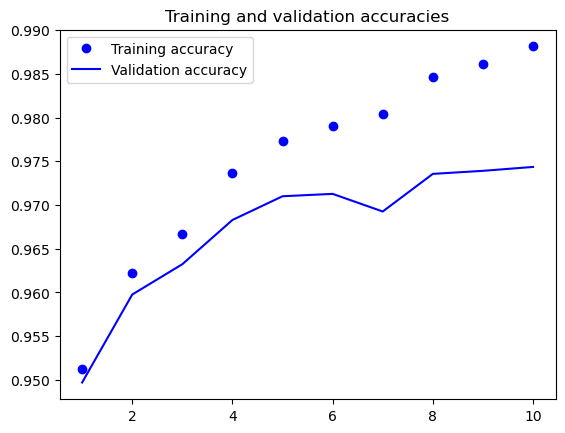

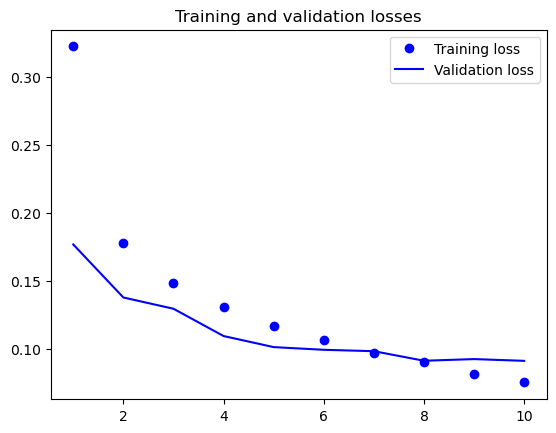

In [71]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

In [72]:
model.eval()

Model(
  (embeddings): Embedding(402597, 50, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

We try the model on a test sentence

In [73]:
sentence = 'The United States might collapsez .'.lower().split()

Convert the sentence words to indices

In [74]:
# Write your code
# The indexes or the unknown word idx
...

The indices. Note the 1 at the end.

In [75]:
print('Sentence', sentence)
print('Sentence word indexes', sentence_word_idxs)

Sentence ['the', 'united', 'states', 'might', 'collapsez', '.']
Sentence word indexes tensor([359698, 374678, 344404, 246008,      1,    936])


Predict the tags. Call the variable `sent_tag_predictions`

In [76]:
# Write your code
sent_tag_predictions = model(sentence_word_idxs)

In [77]:
sent_tag_predictions.shape

torch.Size([6, 10])

The estimated probabilities of the first tag

In [78]:
F.softmax(sent_tag_predictions[0], dim=-1)

tensor([1.9307e-11, 7.2040e-04, 3.8429e-04, 2.3540e-03, 3.3525e-05, 6.9990e-06,
        1.3795e-05, 1.2223e-04, 2.7468e-06, 9.9636e-01],
       grad_fn=<SoftmaxBackward0>)

In [79]:
torch.argmax(F.softmax(sent_tag_predictions, dim=-1), dim=-1)

tensor([9, 1, 5, 9, 9, 9])

We apply argmax to select the tag

In [80]:
for word_nbr, tag_predictions in enumerate(sent_tag_predictions):
    if int(sentence_word_idxs[word_nbr]) in idx2word:
        print(idx2word[int(sentence_word_idxs[word_nbr])], end=': ')
    else:
        print(sentence[word_nbr], '/ukn', end=': ')
    print(idx2tag.get(int(torch.argmax(F.softmax(tag_predictions, dim=-1), dim=-1))))

the: O
united: B-LOC
states: I-LOC
might: O
collapsez /ukn: O
.: O


## Evaluating the Model

In [81]:
test_sentences = read_sentences(test_file)
test_dict = split_rows(test_sentences, column_names)
test_dict[1:2]

[[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O'},
  {'form': 'JAPAN', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-LOC'},
  {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O'},
  {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O'},
  {'form': 'CHINA', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-PER'},
  {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O'},
  {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O'},
  {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'},
  {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]]

We create the ${X}$ and ${Y}$ sequences of symbols

In [82]:
X_test_symbs, Y_test_symbs = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test_symbs[1])
print('Y_test', Y_test_symbs[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


Convert the ${X}$ symbol sequence into an index sequence and pad it. Call the results `X_test_idx` and `X_test_padded`.

In [83]:
# Write your code
X_test_idx = []
for x in X_test_symbs:
    # We map the unknown words to index 1
    x_idx = list(map(lambda a: word2idx.get(a, 1), x))
    X_test_idx += [x_idx]

In [84]:
X_test_idx = map(torch.LongTensor, X_test_idx)

In [85]:
X_test_padded = pad_sequence(X_test_idx, batch_first=True)

In [86]:
print('X_test_padded:', X_test_padded[1])

X_test_padded: tensor([338644,    679, 197600, 162137, 229067, 390518,    517, 100680, 190291,
        350949, 120818,    936,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,  

In [87]:
X_test_padded.shape

torch.Size([3684, 124])

Predict the NER tags. Call the result `Y_test_hat_probs`

In [88]:
# Write your code
Y_test_hat_probs = ...

In [89]:
print('Predictions', Y_test_hat_probs[1])

Predictions tensor([[-22.8786,  -6.0988,  -2.8765,  ...,  -4.9251,  -7.5867,   5.7021],
        [-28.1003,  -5.7314,  -4.7418,  ...,  -7.4599, -11.6163,   7.3182],
        [-22.2208,   3.8258,   0.4744,  ...,  -7.0851,  -8.8217,  -3.0838],
        ...,
        [-15.6206,  -3.1608,  -1.3423,  ...,  -5.2927,  -5.2132,   3.3497],
        [-12.2659,  -2.6003,  -0.9055,  ...,  -4.3945,  -4.2848,   2.5429],
        [ -9.5074,  -2.3474,  -0.8784,  ...,  -3.3730,  -3.2490,   1.8084]],
       grad_fn=<SelectBackward0>)


In [90]:
Y_test_hat_probs = F.softmax(Y_test_hat_probs, dim=-1)

In [91]:
Y_test_hat_probs[1]

tensor([[3.8675e-13, 7.4954e-06, 1.8804e-04,  ..., 2.4241e-05, 1.6929e-06,
         9.9967e-01],
        [4.1488e-16, 2.1510e-06, 5.7865e-06,  ..., 3.8189e-07, 5.9818e-09,
         9.9998e-01],
        [4.6318e-12, 9.4982e-01, 3.3274e-02,  ..., 1.7340e-05, 3.0540e-06,
         9.4806e-04],
        ...,
        [5.6829e-09, 1.4649e-03, 9.0277e-03,  ..., 1.7376e-04, 1.8814e-04,
         9.8470e-01],
        [3.4970e-07, 5.5131e-03, 3.0022e-02,  ..., 9.1664e-04, 1.0229e-03,
         9.4424e-01],
        [1.0314e-05, 1.3273e-02, 5.7670e-02,  ..., 4.7595e-03, 5.3875e-03,
         8.4688e-01]], grad_fn=<SelectBackward0>)

We now predict the whole test set and we store the results in each dictionary with the key `pner`

In [92]:
for sent, y_hat_probs in zip(test_dict, Y_test_hat_probs):
    sent_len = len(sent)
    y_hat_probs = y_hat_probs[:sent_len]
    # y_hat = torch.argmax(y_hat_probs, dim=-1) # This statement sometimes predicts 0 (the padding symbol)
    y_hat = torch.argmax(y_hat_probs[:, 1:], dim=-1) + 1 # Never predicts 0
    for word, ner_hat in zip(sent, y_hat):
        word['pner'] = idx2tag.get(int(ner_hat)) 
        if word['pner'] == None:
            print(sent)

A sentence example: `ner` is the hand annotation and `pner` is the prediction.

In [93]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-LOC',
  'pner': 'B-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-PER',
  'pner': 'B-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

We save the test set in a file to evaluate the performance of our model.

In [94]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [95]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [96]:
outfile = 'test_model.out'

In [97]:
save(outfile, test_dict, column_names)

In [98]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
chunker_score = res['overall']['chunks']['evals']['f1']
chunker_score

0.8514851485148514

In [99]:
config

{'EPOCHS': 10,
 'LSTM_HIDDEN_DIM': 128,
 'LSTM_LAYERS': 2,
 'DROPOUT': 0.2,
 'EMB_LARGE': False,
 'FREEZE_EMBS': True}

In [100]:
torch.save(model.state_dict(), 'model.pth')

## Experiments

You will carry out experiments with two different recurrent networks: RNN and LSTM. You will also try at least two sets of parameters per network. In your report, you will present your results in a table like this one:

|Method|Parameters|Score|
|------|-----|-----|
|Baseline|  xx | xx |
|RNN|  xx |xx |
|RNN |  xx |xx |
|LSTM |  xx |xx |
|LSTM |  xx |xx |

The baseline is the one from the CoNLL 2003 share task. See here: https://aclanthology.org/W03-0419.pdf

You need to reach 80 to pass the lab

## Turning in your assignment

Now your are done with the program. To complete this assignment, you will:
1. Write a short individual report on your program. You will describe the architecture your used the different experiments you carried out and your results.


Submit your report as well as your notebook (for archiving purposes) to Canvas: https://canvas.education.lu.se/. To write your report, you can either
1. Write directly your text in Canvas, or
2. Use Latex and Overleaf (www.overleaf.com). This will probably help you structure your text. You will then upload a PDF file in Canvas.
